# 数据分析

## 数据load & filter

In [1]:
import gzip
import numpy as np

def un_gz(file_name):
    g_file = gzip.GzipFile(file_name)   
    return g_file.readlines()

def get_label_3(name):
    ans = name.split("_")
    if ans[2] == 'oocyte' or 'Hoechst' in name:
        return 'oocyte'
    else:
        return '_'.join(ans[2].split('-')[0:2])
    
def get_label_4(name):
    ans = name.split("_")
    if ans[2] == 'oocyte':
        outputs = 'oocyte_' + ans[3].split('-')[0]
        return outputs
    elif 'Hoechst' in name:
        return 'oocyte_' + ans[2].split('-')[0]
    else:
        return '_'.join(ans[2].split('-')[0:2])

def get_label_num(name):
    ans = name.split("_")
    if ans[2] == 'oocyte' or 'Hoechst' in name:
        return 0
    else:
        if ans[2].split('-')[1] == 'male':
            return 1
        else:
            return 2
        
        
mm9_chromsize = {'chr1': 197195432,
'chr2': 181748087,
'chr3': 159599783,
'chr4': 155630120,
'chr5': 152537259,
'chr6': 149517037,
'chr7': 152524553,
'chr8': 131738871,
'chr9': 124076172,
'chr10': 129993255,
'chr11': 121843856,
'chr12': 121257530,
'chr13': 120284312,
'chr14': 125194864,
'chr15': 103494974,
'chr16': 98319150,
'chr17': 95272651,
'chr18': 90772031,
'chr19': 61342430,
'chrX': 166650296}

def quality_check(cell_dict):
    total_contact = 0
    for key, matrix in cell_dict.items():
        matrix_non_diag = np.triu(matrix) - np.diag(np.diag(matrix))
        contact_num = matrix_non_diag.sum()
#         if contact_num < mm9_chromsize[key] // 20000000:
#             return False
        total_contact += contact_num
    if total_contact > 5000:
        return True
    else:
        return False
    
def process_one_cell(path, filename):
    cell_dict = {}
    for key,value in mm9_chromsize.items():
        length = value // 1000000 + 1
        cell_dict[key] = np.zeros([length, length])
    dataframe = un_gz(path + filename)
    for line in dataframe[1:]:
        chr1, chr2, s1, e1, s2, e2, num = line.decode('UTF-8').strip().split(',')
        if chr1 == chr2:
            bin1 = int(s1) // 1000000
            bin2 = int(s2) // 1000000
            cell_dict['chr' + chr1][bin1][bin2] += int(num)
            
    for key in mm9_chromsize.keys():
        cell_dict[key] = cell_dict[key] + cell_dict[key].T - np.diag(np.diag(cell_dict[key]))
    if quality_check(cell_dict):
        return cell_dict, get_label_3(filename), get_label_4(filename), get_label_num(filename)
    else:
        return None, None, None, None

In [2]:
import os
path = "data/raw_data/"
gz_files = os.listdir(path)
cell_data = []
cell_label_3 = []
cell_label_4 = []
cell_label_num = []
for filename in gz_files:
    cell_dict, label_3, label_4, label_num = process_one_cell(path, filename)
    if cell_dict != None:
        cell_data.append(cell_dict)
        cell_label_3.append(label_3)
        cell_label_4.append(label_4)
        cell_label_num.append(label_num)

In [3]:
cell_type = {'oocyte': 0, 'pronucleus_male': 0, 'pronucleus_female': 0}
for cell in cell_label_3:
    cell_type[cell] += 1
cell_type


{'oocyte': 93, 'pronucleus_male': 18, 'pronucleus_female': 23}

In [4]:
# np.save('cell_matrix.npy', cell_data)
# np.save('cell_label_3.npy', cell_label_3)
# np.save('cell_label_4.npy', cell_label_4)
# np.save('cell_label_num.npy', cell_label_num)

## 统计一下指标

In [5]:
import numpy as np
cell_data = np.load('cell_matrix.npy', allow_pickle=True)

In [9]:
def get_cell_counts(cell_dict):
    all_count, non_diagonal_count = 0, 0
    for chr, matrix in cell_dict.items():
        all_count += np.triu(matrix).sum()
        non_diagonal_count += (np.triu(matrix) - np.diag(np.diag(matrix))).sum()
    return all_count, non_diagonal_count

def cal_list(array):
    a_min = min(array)
    a_max = max(array)
    sum = 0
    for i in array:
        sum += i
    mean = sum / len(array)

    data = sorted(array)
    length = len(array)
    if length%2 == 0:
        median = (data[length//2-1] + data[length//2]) / 2
    else:
        median = data[(length-1)//2]

    return mean, a_min, median, a_max

def get_statistics(cell_data):
    all_counts = [get_cell_counts(cell)[0] for cell in cell_data]
    non_diagonal_counts = [get_cell_counts(cell)[1] for cell in cell_data]
    print("all counts: ", cal_list(all_counts))
    print("non_diagonal_counts: ", cal_list(non_diagonal_counts))

get_statistics(cell_data)

all counts:  (287501.46268656716, 21668.0, 190538.0, 1654572.0)
non_diagonal_counts:  (95580.87313432836, 5137.0, 40867.0, 683165.0)


## Plot 看一下


### PCA

In [191]:
from sklearn.decomposition import PCA
import numpy as np

matrix = []
chrom_matrix = {}
chroms = [item for item in cell_data[0].keys()]
for chrom in chroms:
    chrom_matrix[chrom] = []
for cell in cell_data:
    for item in cell.items():
        chrom_matrix[item[0]].append(item[1].reshape(1, -1))
for chrom in chroms:
    chrom_matrix[chrom] = np.concatenate(chrom_matrix[chrom], axis=0)
    A = chrom_matrix[chrom]
    pca = PCA(n_components = 20)
    R_reduce = pca.fit_transform(A)
    matrix.append(R_reduce)
matrix = np.concatenate(matrix, axis=1)
print('matrix.shape:', matrix.shape)

pca = PCA(n_components = 20)
matrix_reduce = pca.fit_transform(matrix)

matrix.shape: (134, 400)


In [195]:
# ACC ARI NMI
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score

def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind = linear_assignment(w.max() - w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

y_pred = KMeans(n_clusters = 3, n_init = 200).fit_predict(matrix_reduce)
acc = acc(np.array(cell_label_num), y_pred)
ari = adjusted_rand_score(cell_label_3, y_pred)
nmi = normalized_mutual_info_score(cell_label_3, y_pred)
print("Kmeans acc: %.5f, NMI: %.5f, ARI: %.5f" % (acc, nmi, ari))

Kmeans acc: 0.39552, NMI: 0.08873, ARI: -0.06563


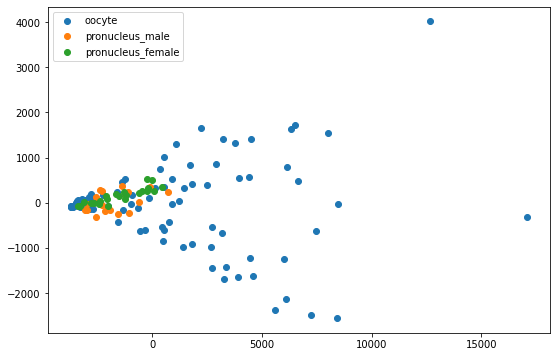

In [193]:
cell_type = {'oocyte': 93, 'pronucleus_male': 18, 'pronucleus_female': 23}
cell_x = {}
cell_y = {}
for key in cell_type.keys():
    cell_x[key] = []
    cell_y[key] = []
for i in range(len(matrix_reduce)):
    cell_x[cell_label_3[i]].append(matrix_reduce[i][0])
    cell_y[cell_label_3[i]].append(matrix_reduce[i][1])

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9,6))
cell_ax = []
label_ax = []
for key in cell_type.keys():
    cell_ax.append(ax.scatter(cell_x[key], cell_y[key]))
    label_ax.append(key)

ax.legend(cell_ax, label_ax, loc = 0)

plt.show()

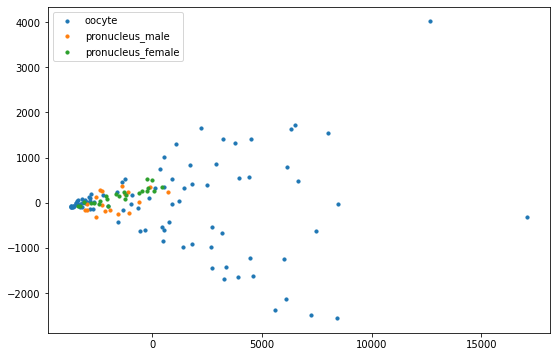

In [194]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca')
matrix_tsne = tsne.fit_transform(matrix_reduce)
cell_type = {'oocyte': 114, 'pronucleus_male': 24, 'pronucleus_female': 31}
cell_x = {}
cell_y = {}
for key in cell_type.keys():
    cell_x[key] = []
    cell_y[key] = []
for i in range(len(matrix_reduce)):
    cell_x[cell_label_3[i]].append(matrix_reduce[i][0])
    cell_y[cell_label_3[i]].append(matrix_reduce[i][1])

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9,6))
cell_ax = []
label_ax = []
for key in cell_type.keys():
    cell_ax.append(ax.scatter(cell_x[key], cell_y[key], s=10))
    label_ax.append(key)

ax.legend(cell_ax, label_ax, loc = 0)
plt.show()


### scHiCluster

In [4]:
from sklearn.decomposition import PCA
import numpy as np
import time

def neighbor_ave_cpu(A, pad):
    if pad==0:
        return A
    ngene, _ = A.shape
    ll = pad * 2 + 1
    B, C, D, E = [np.zeros((ngene + ll, ngene + ll)) for i in range(4)]
    B[(pad + 1):(pad + ngene + 1), (pad + 1):(pad + ngene + 1)] = A[:]
    F = B.cumsum(axis = 0).cumsum(axis = 1)
    C[ll :, ll:] = F[:-ll, :-ll]
    D[ll:, :] = F[:-ll, :]
    E[:, ll:] = F[:, :-ll]
    return (np.around(F + C - D - E, decimals=8)[ll:, ll:] / float(ll * ll))

def random_walk_cpu(A, rp):
    ngene, _ = A.shape
    A = A - np.diag(np.diag(A))
    A = A + np.diag(np.sum(A, axis=0) == 0)
    P = np.divide(A, np.sum(A, axis = 0))
    Q = np.eye(ngene)
    I = np.eye(ngene)
    for i in range(30):
        Q_new = (1 - rp) * I + rp * np.dot(Q, P)
        delta = np.linalg.norm(Q - Q_new)
        Q = Q_new.copy()
        if delta < 1e-6:
            break
    return Q

def impute_cpu(A, pad, rp):
#     A = np.log2(A + A.T + 1 - np.diag(np.diag(A)))
    A = np.log2(A + 1)
    A = neighbor_ave_cpu(A, pad)
    Q = random_walk_cpu(A, rp)
    return Q

cell_num = len(cell_data)
matrix = []
for chrom, size in mm9_chromsize.items():
    start_time = time.time()
    size = size // 1000000 + 1
    Q_concat = np.zeros((cell_num, size*size))
    for j, cell in enumerate(cell_data):
        Q_concat[j] = impute_cpu(cell_data[j][chrom], pad=1, rp=0.5).reshape(-1)
    thres = np.percentile(Q_concat, 80, axis=1)
    Q_concat = (Q_concat > thres[:,None])
    end_time = time.time()
    print('Load and impute chromosome', chrom, 'take', end_time - start_time, 'seconds')
    pca = PCA(n_components = 20)
    R_reduce = pca.fit_transform(Q_concat)
#     R_reduce = Q_concat
    matrix.append(R_reduce)
matrix = np.concatenate(matrix, axis=1)
print('matrix.shape: ', matrix.shape)
pca = PCA(n_components = 100)
matrix_reduce = pca.fit_transform(matrix)


Load and impute chromosome chr1 take 3.2282299995422363 seconds
Load and impute chromosome chr2 take 3.195491313934326 seconds
Load and impute chromosome chr3 take 1.8015673160552979 seconds
Load and impute chromosome chr4 take 2.9913699626922607 seconds
Load and impute chromosome chr5 take 2.2691755294799805 seconds
Load and impute chromosome chr6 take 3.5524749755859375 seconds
Load and impute chromosome chr7 take 2.2792086601257324 seconds
Load and impute chromosome chr8 take 2.100266933441162 seconds
Load and impute chromosome chr9 take 1.4656434059143066 seconds
Load and impute chromosome chr10 take 1.9275639057159424 seconds
Load and impute chromosome chr11 take 1.3421735763549805 seconds
Load and impute chromosome chr12 take 2.0283496379852295 seconds
Load and impute chromosome chr13 take 2.7863783836364746 seconds
Load and impute chromosome chr14 take 2.257549285888672 seconds
Load and impute chromosome chr15 take 0.8647668361663818 seconds
Load and impute chromosome chr16 take

In [8]:
# ACC ARI NMI
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score

def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind = linear_assignment(w.max() - w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

y_pred = KMeans(n_clusters = 3, n_init = 200).fit_predict(matrix_reduce)
acc = acc(np.array(cell_label_num), y_pred)
ari = adjusted_rand_score(cell_label_3, y_pred)
nmi = normalized_mutual_info_score(cell_label_3, y_pred)
print("Kmeans acc: %.5f, NMI: %.5f, ARI: %.5f" % (acc, nmi, ari))

Kmeans acc: 0.92537, NMI: 0.73568, ARI: 0.80998


n_init=200
Kmeans acc: 0.94030, NMI: 0.77526, ARI: 0.84143
Kmeans acc: 0.91045, NMI: 0.71911, ARI: 0.75699

n_init=2000
Kmeans acc: 0.91791, NMI: 0.72110, ARI: 0.78842
Kmeans acc: 0.92537, NMI: 0.74507, ARI: 0.79827

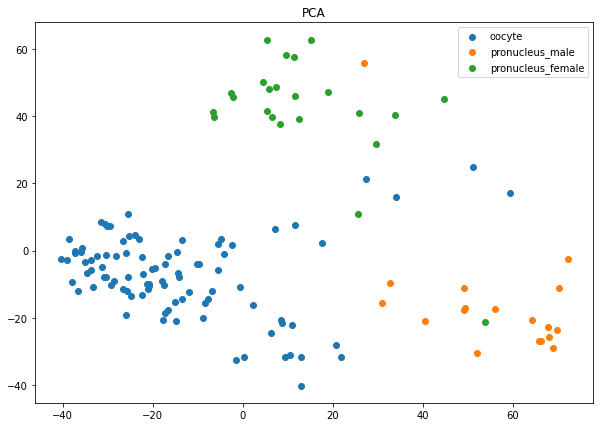

In [9]:
cell_type = {'oocyte': 93, 'pronucleus_male': 18, 'pronucleus_female': 23}
cell_x = {}
cell_y = {}
for key in cell_type.keys():
    cell_x[key] = []
    cell_y[key] = []
for i in range(len(matrix_reduce)):
    cell_x[cell_label_3[i]].append(matrix_reduce[i][0])
    cell_y[cell_label_3[i]].append(matrix_reduce[i][1])

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,7))
cell_ax = []
label_ax = []
for key in cell_type.keys():
    cell_ax.append(ax.scatter(cell_x[key], cell_y[key]))
    label_ax.append(key)

ax.legend(cell_ax, label_ax, loc = 0)
ax.set_title('PCA')
plt.show()

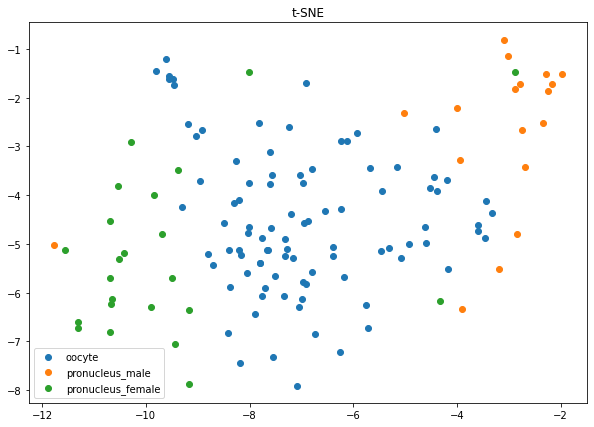

In [14]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca')
matrix_tsne = tsne.fit_transform(matrix_reduce)
cell_type = {'oocyte': 114, 'pronucleus_male': 24, 'pronucleus_female': 31}
cell_x = {}
cell_y = {}
for key in cell_type.keys():
    cell_x[key] = []
    cell_y[key] = []
for i in range(len(matrix_reduce)):
    cell_x[cell_label_3[i]].append(matrix_tsne[i][0])
    cell_y[cell_label_3[i]].append(matrix_tsne[i][1])

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,7))
cell_ax = []
label_ax = []
for key in cell_type.keys():
    cell_ax.append(ax.scatter(cell_x[key], cell_y[key]))
    label_ax.append(key)

ax.legend(cell_ax, label_ax, loc = 0)
ax.set_title('t-SNE')
plt.show()


## scHiCluster二值化矩阵存

In [197]:
from sklearn.decomposition import PCA
import numpy as np
import time

def neighbor_ave_cpu(A, pad):
    if pad==0:
        return A
    ngene, _ = A.shape
    ll = pad * 2 + 1
    B, C, D, E = [np.zeros((ngene + ll, ngene + ll)) for i in range(4)]
    B[(pad + 1):(pad + ngene + 1), (pad + 1):(pad + ngene + 1)] = A[:]
    F = B.cumsum(axis = 0).cumsum(axis = 1)
    C[ll :, ll:] = F[:-ll, :-ll]
    D[ll:, :] = F[:-ll, :]
    E[:, ll:] = F[:, :-ll]
    return (np.around(F + C - D - E, decimals=8)[ll:, ll:] / float(ll * ll))

def random_walk_cpu(A, rp):
    ngene, _ = A.shape
    A = A - np.diag(np.diag(A))
    A = A + np.diag(np.sum(A, axis=0) == 0)
    P = np.divide(A, np.sum(A, axis = 0))
    Q = np.eye(ngene)
    I = np.eye(ngene)
    for i in range(30):
        Q_new = (1 - rp) * I + rp * np.dot(Q, P)
        delta = np.linalg.norm(Q - Q_new)
        Q = Q_new.copy()
        if delta < 1e-6:
            break
    return Q

def impute_cpu(A, pad, rp):
#     A = np.log2(A + A.T + 1 - np.diag(np.diag(A)))
    A = np.log2(A + 1)
    A = neighbor_ave_cpu(A, pad)
    Q = random_walk_cpu(A, rp)
    return Q

cell_num = len(cell_data)
matrix = {}
for chrom, size in mm9_chromsize.items():
    start_time = time.time()
    size = size // 1000000 + 1
    Q_concat = np.zeros((cell_num, size*size))
    for j, cell in enumerate(cell_data):
        Q_concat[j] = impute_cpu(cell_data[j][chrom], pad=1, rp=0.5).reshape(-1)
    thres = np.percentile(Q_concat, 80, axis=1)
    Q_concat = (Q_concat > thres[:,None])
    Q_concat = Q_concat.reshape(((cell_num, size, size)))
    end_time = time.time()
    print('Load and impute chromosome', chrom, 'take', end_time - start_time, 'seconds')
    matrix[chrom] = Q_concat


embedding_data = []
for i in range(cell_num):
    cell_dict = {}
    for chr in mm9_chromsize.keys():
        cell_dict[chr] = matrix[chr][i]
    embedding_data.append(cell_dict)

Load and impute chromosome chr1 take 5.838546514511108 seconds
Load and impute chromosome chr2 take 3.1973929405212402 seconds
Load and impute chromosome chr3 take 2.6359364986419678 seconds
Load and impute chromosome chr4 take 3.365802049636841 seconds
Load and impute chromosome chr5 take 2.9756460189819336 seconds
Load and impute chromosome chr6 take 2.1785058975219727 seconds
Load and impute chromosome chr7 take 4.582333564758301 seconds
Load and impute chromosome chr8 take 4.518694639205933 seconds
Load and impute chromosome chr9 take 2.092296600341797 seconds
Load and impute chromosome chr10 take 3.2955336570739746 seconds
Load and impute chromosome chr11 take 2.539118528366089 seconds
Load and impute chromosome chr12 take 1.7128074169158936 seconds
Load and impute chromosome chr13 take 1.9932212829589844 seconds
Load and impute chromosome chr14 take 2.375521421432495 seconds
Load and impute chromosome chr15 take 2.540703058242798 seconds
Load and impute chromosome chr16 take 1.66

In [198]:
np.save("cell_matrix_scHiCluster_01.npy", embedding_data)
